In [1]:
import pickle
import numpy as np
import pandas as pd

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns


In [3]:
with open('/data/longterm/10/athira/Jan26_preSeminarResults/kNN_obj.pkl', 'rb') as knn_model:
    neigh = pickle.load(knn_model)

In [4]:
with open('/data/longterm/10/athira/Jan26_preSeminarResults/dbscan_results.pkl', 'rb') as dbscan_file:
    clustering = pickle.load(dbscan_file)

In [5]:
clustering.get_params()

{'algorithm': 'auto',
 'eps': 10,
 'leaf_size': 30,
 'metric': 'euclidean',
 'metric_params': None,
 'min_samples': 2000,
 'n_jobs': 46,
 'p': None}

In [6]:
label_map_db = {}
for i, label in enumerate(np.unique(clustering.labels_)):
    label_map_db[label] = i

c_pal_db = sns.color_palette('tab10',len(np.unique(clustering.labels_))+1)

In [7]:
df_drug_features_combined = pd.read_pickle('/data/longterm/10/athira/July17_features_combined_noLightStimuli.pickle')

In [8]:
df_drug_tsne_results = pd.read_pickle('/data/longterm/10/athira/Jan26_preSeminarResults/tsne_drug_results_clus.pkl')

In [9]:
df_control_tsne_results = pd.read_pickle('/data/longterm/10/athira/Jan26_preSeminarResults/tsne_control_results_clus.pkl')

In [10]:
df_drug_tsne_results = pd.concat([df_drug_tsne_results,df_control_tsne_results])

In [11]:
df_drug_tsne_results['drug'] = df_drug_tsne_results['filename'].apply(lambda x: x.split('_')[4])
df_drug_tsne_results

,filename,frames,tsne_proj_0,tsne_proj_1,clus_db,drug
0,20180823_131829_1_15m0s_Raclopride_None_None_s...,0,-47.473202,-4.494886,1,Raclopride
1,20180823_131829_1_15m0s_Raclopride_None_None_s...,1,-43.945462,-15.053187,1,Raclopride
2,20180823_131829_1_15m0s_Raclopride_None_None_s...,2,-43.207392,-12.956910,1,Raclopride
3,20180823_131829_1_15m0s_Raclopride_None_None_s...,3,-43.271015,-12.929424,1,Raclopride
4,20180823_131829_1_15m0s_Raclopride_None_None_s...,4,-43.048086,-12.866921,1,Raclopride
...,...,...,...,...,...,...
6603504,20180813_091833_1_5m0s_None_None_None_skeleton...,8997,-60.037655,12.030477,1,None
6603505,20180813_091833_1_5m0s_None_None_None_skeleton...,8998,-59.793390,11.860528,1,None
6603506,20180813_091833_1_5m0s_None_None_None_skeleton...,8999,-59.888531,11.807174,1,None
6603507,20180813_091833_1_5m0s_None_None_None_skeleton...,9000,-70.261227,5.722007,1,None


In [12]:
# df_drug_clusters = pd.merge(df_drug_tsne_results, df_drug_features_combined, left_on=['filename','frames'], right_on=['filename','frames'],
#         left_index=True, how='left' )
# df_drug_clusters.head()

In [12]:
df_drug_tsne_results = pd.read_pickle('/data/longterm/10/athira/Jan26_preSeminarResults/tsne_control_and_drugs_results_clus.pkl')

In [13]:
stim_name_list = list(df_drug_tsne_results.drug.unique())
len(stim_name_list)

18

In [14]:
stim_name_list

['Raclopride',
 'Paroxetine',
 'Fluoxetine',
 'Methiothepin',
 'Clomipramine',
 'Serotonin',
 'Alphamethyl',
 'Tyramine',
 'Dopamine',
 'Imipramine',
 'Chlorpromazine',
 'AA',
 'Phentolamine',
 'Quinpirole0003',
 'Octopamine',
 'Mianserin',
 'Quinpirole003',
 'None']

In [ ]:
# fig, axes = plt.subplots(6,3,figsize=(12, 36), sharex=True, sharey=True)

# axes = axes.ravel()
# for j in range(len(stim_name_list)): 
#     df_stim =df_drug_tsne_results[df_drug_tsne_results['drug'] == stim_name_list[j]]
    
#     df = df_stim#.sample(60000) 
    
#     clus_drug = list(df['clus_db'])
#     colors_drug = [c_pal_db[label_map_db[clus_drug[i]]] for i in range(len(clus_drug)) ]
#     axes[j].scatter(df['tsne_proj_0'],df['tsne_proj_1'], c= colors_drug, s=0.1, alpha=0.5)
#     axes[j].set_title(f'{j},{stim_name_list[j]}')

## Try getting pdfs

In [15]:
from scipy.ndimage.filters import gaussian_filter

In [16]:
from scipy.ndimage.filters import gaussian_filter
import matplotlib.cm as cm

In [17]:
import tqdm

In [18]:
def gaussian_kernel(l = 3, sig = 1):
    x_axis = np.linspace(-l/2, l/2, l)
    xx, yy = np.meshgrid(x_axis, x_axis)
    kernel = np.exp(-0.5 * (np.square(xx) + np.square(yy)) / np.square(sig))
    return kernel

def filter_per_datapoint(tsne_proj, point, padded_image, filtered_image, n_neighbours = 10, sigma = 1):
    #take the 10th-closest point-to-point distance as the kernel size. We will have to choose the closest odd integer I suppose.
    distance = int(np.sort(np.linalg.norm(tsne_proj - point, axis = 1))[n_neighbours+1])
    
    #closest odd integer
    if distance%2==0:
        distance+=1
    #step size to place the kernel centrally on pixel of interest
    step = distance//2
    
    #get kernel
    gk = gaussian_kernel(distance, 1)
    
    #calculate pixels from original dataset
    x = int(point[0]-np.min(tsne_proj[:,0]))
    y = int(point[1]-np.min(tsne_proj[:,1]))
    
    #apply filter to pixel
    filtered_image[x,y] = np.sum(gk*padded_image[x+10-step:x+10+step+1, y+10-step:y+10+step+1])
    return filtered_image

In [19]:
def myplot(x, y, s, bins= 5000):
    heatmap, xedges, yedges = np.histogram2d(x, y, bins=bins, normed=True)
    heatmap = gaussian_filter(heatmap, sigma=s)

    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
    return heatmap.T, extent

In [20]:
def myplot_norm(x, y, s, bins= 5000):
    heatmap, xedges, yedges = np.histogram2d(x, y, bins=bins, normed=True)
    heatmap = heatmap/np.max(heatmap)
    print(np.max(heatmap), np.min(heatmap))
    heatmap = gaussian_filter(heatmap, sigma=s)

    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
    return heatmap.T, extent

In [23]:
stim_name_list =['Clomipramine',
 'Methiothepin',
 'Chlorpromazine',
 'Imipramine',
 'Mianserin',
 'Fluoxetine',
 'Phentolamine',
 'None', 
 'Raclopride']

In [21]:
x_max = np.floor(df_drug_tsne_results['tsne_proj_0'].max())
x_min = np.floor(df_drug_tsne_results['tsne_proj_0'].min())
y_max = np.floor(df_drug_tsne_results['tsne_proj_1'].max())
y_min = np.floor(df_drug_tsne_results['tsne_proj_1'].min())

In [22]:
x_max = 100
x_min = -100
y_max = 100
y_min = -100

1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0


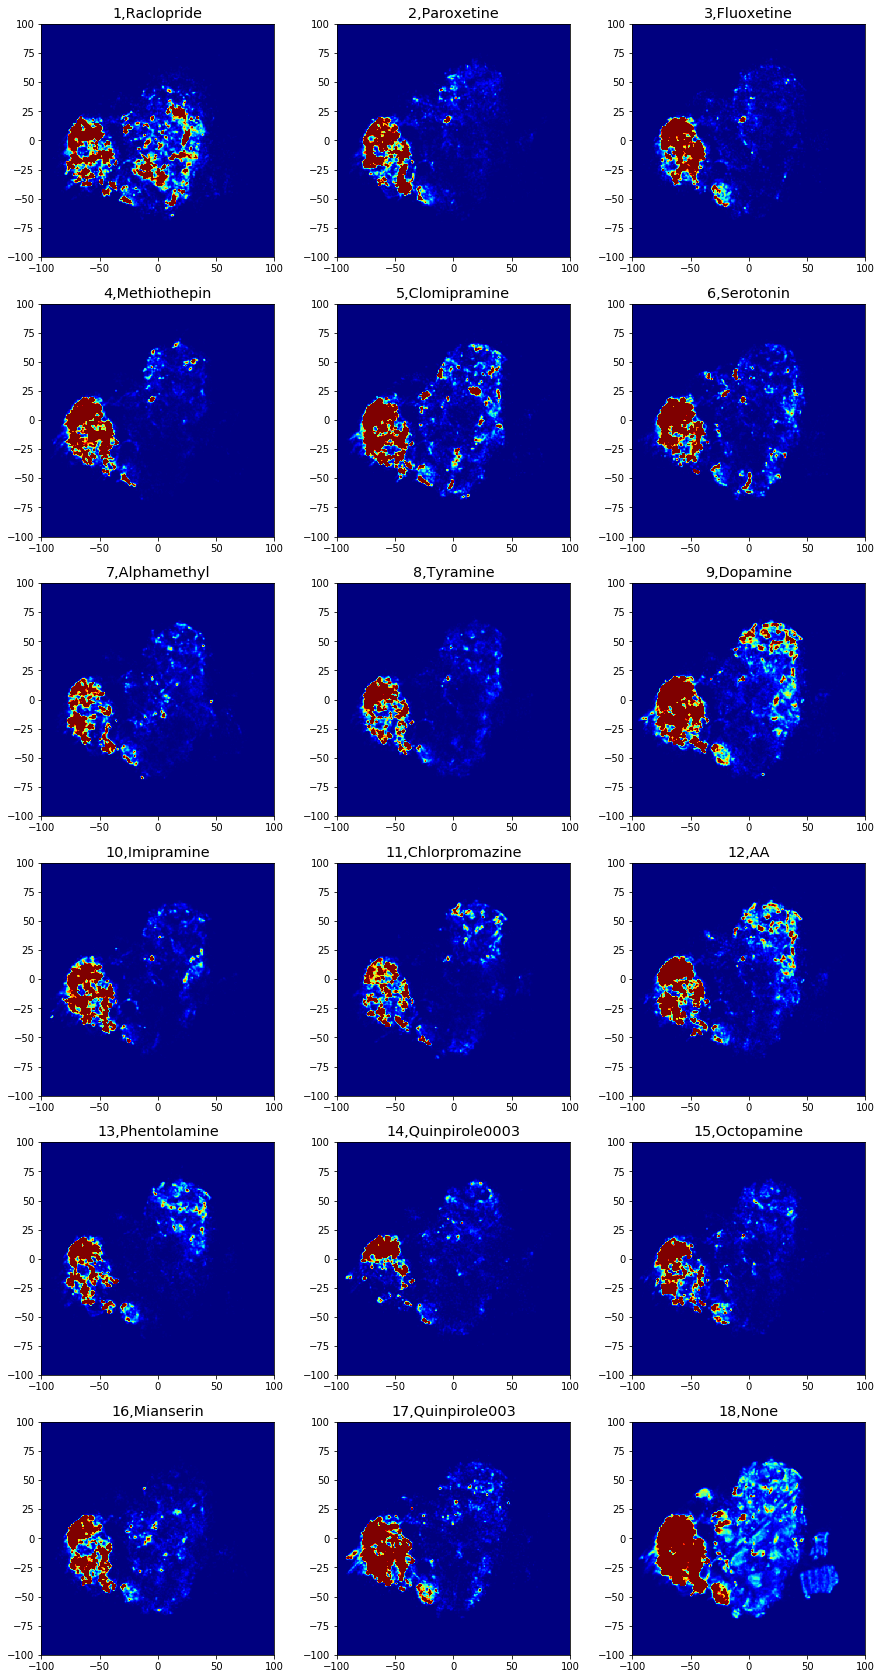

In [25]:
for _scale in [0.008]:

    fig, axes = plt.subplots(6,3,figsize=(15,30))

    axes = axes.ravel()
    for j, drug in enumerate(stim_name_list): 
        df_stim =df_drug_tsne_results[df_drug_tsne_results['drug'] == drug]

        tsne_proj = df_stim.filter(like = 'tsne_proj_')

        tsne_data = np.array(tsne_proj.values)
        xrange = np.max(tsne_data[:,0]) - np.min(tsne_data[:,0])
        yrange = np.max(tsne_data[:,1]) - np.min(tsne_data[:,1])

        bins = [np.int(np.floor(xrange))+2, np.int(np.floor(yrange))+1]

        xbins = np.linspace(x_min, x_max, num = 400)
        ybins = np.linspace(y_min, y_max, num = 400)
        bins = [xbins, ybins]

        img, extent = myplot_norm(df_stim['tsne_proj_0'],df_stim['tsne_proj_1'], 1, bins = bins)
#         _scale = 0.1
        axes[j].imshow(img, extent=extent, origin='lower', cmap=cm.jet, vmax = _scale*np.max(img), vmin= 0)
        axes[j].set_title(f'{j+1},{drug}', size='x-large')
        axes[j].set_xlim([-100,100])
        axes[j].set_ylim([-100,100])

    fig.savefig(f'../../ciona_tierpsy_behavior/Figures/tsne_results/drugs_tsne_rescaled_aug2/drugs_pdf_{_scale}vmax.svg')

# Tests

In [ ]:
fig, axes = plt.subplots(3,6,figsize=(30,15))

axes = axes.ravel()
for j, drug in enumerate(stim_name_list): 
    df_stim =df_drug_tsne_results[df_drug_tsne_results['drug'] == drug]

    tsne_proj = df_stim.filter(like = 'tsne_proj_')

    tsne_data = np.array(tsne_proj.values)
    xrange = np.max(tsne_data[:,0]) - np.min(tsne_data[:,0])
    yrange = np.max(tsne_data[:,1]) - np.min(tsne_data[:,1])
    
    bins = [np.int(np.floor(xrange))+2, np.int(np.floor(yrange))+1]
#     print(bins)
    img, extent = myplot(df_stim['tsne_proj_0'],df_stim['tsne_proj_1'], 1, bins = bins)
#     print(np.max(img),np.min(img))
#     axes[j].imshow(img, extent=extent, origin='lower', cmap=cm.jet)
#     axes[j].set_title(f'{j},{drug}')
    _scale = 1
    axes[j].imshow(img, extent=extent, origin='lower', cmap=cm.jet, vmax = _scale*np.max(img), vmin= 0)
    axes[j].set_title(f'{j+1},{drug}', size='x-large')
#     axes[j+8].imshow(img, extent=extent, origin='lower', cmap=cm.jet, vmax = 0.3*np.max(img), vmin= 0)
#     axes[j+8].set_title(f'{j},{drug}')
#     axes[j+12].imshow(img, extent=extent, origin='lower', cmap=cm.jet, vmax = 0.1*np.max(img), vmin= 0)
#     axes[j+12].set_title(f'{j},{drug}')
# fig.savefig(f'../../ciona_tierpsy_behavior/Figures/tsne_results/drugs_tsne_pdfs_1/drugs_pdf_comparisons_{_scale}vmax.svg')

In [ ]:
fig, axes = plt.subplots(4,2,figsize=(8,16))
axes = axes.ravel()
for j, drug in enumerate(['Raclopride', 'Dopamine']): 
    df_stim =df_drug_tsne_results[df_drug_tsne_results['drug'] == drug]
    df_stim = df_drug_tsne_results[df_drug_tsne_results['drug'] == drug]

    tsne_proj = df_stim.filter(like = 'tsne_proj_')

    tsne_data = np.array(tsne_proj.values)
    xrange = np.max(tsne_data[:,0]) - np.min(tsne_data[:,0])
    yrange = np.max(tsne_data[:,1]) - np.min(tsne_data[:,1])
    
    bins = [np.int(np.floor(xrange))+2, np.int(np.floor(yrange))+1]
    print(bins)
    img, extent = myplot(df_stim['tsne_proj_0'],df_stim['tsne_proj_1'], 1, bins = bins)
    print(np.max(img),np.min(img))
    axes[j].imshow(img, extent=extent, origin='lower', cmap=cm.jet)
    axes[j].set_title(f'{j},{drug}')
    axes[j+2].imshow(img, extent=extent, origin='lower', cmap=cm.jet, vmax = 0.05*np.max(img), vmin= 0)
    axes[j+2].set_title(f'{j},{drug}')
    axes[j+4].imshow(img, extent=extent, origin='lower', cmap=cm.jet, vmax = 0.3*np.max(img), vmin= 0)
    axes[j+4].set_title(f'{j},{drug}')
    axes[j+6].imshow(img, extent=extent, origin='lower', cmap=cm.jet, vmax = 0.1*np.max(img), vmin= 0)
    axes[j+6].set_title(f'{j},{drug}')

In [ ]:
fig, axes = plt.subplots(4,2,figsize=(16,16))
axes = axes.ravel()
for j, drug in enumerate(['Quinpirole003', 'Quinpirole0003']): 
    df_stim =df_drug_tsne_results[df_drug_tsne_results['drug'] == drug]
    df_stim = df_drug_tsne_results[df_drug_tsne_results['drug'] == drug]

    tsne_proj = df_stim.filter(like = 'tsne_proj_')

    tsne_data = np.array(tsne_proj.values)
    xrange = np.max(tsne_data[:,0]) - np.min(tsne_data[:,0])
    yrange = np.max(tsne_data[:,1]) - np.min(tsne_data[:,1])
    
    bins = [np.int(np.floor(xrange))+2, np.int(np.floor(yrange))+1]
#     print(bins)
    img, extent = myplot_norm(df_stim['tsne_proj_0'],df_stim['tsne_proj_1'], 1, bins = bins)
#     print(np.max(img),np.min(img))
    axes[j].imshow(img, extent=extent, origin='lower', cmap=cm.jet)
    axes[j].set_title(f'{j},{drug}')
    axes[j+2].imshow(img, extent=extent, origin='lower', cmap=cm.jet, vmax = 0.05*np.max(img), vmin= 0)
    axes[j+2].set_title(f'{j},{drug}')
    axes[j+4].imshow(img, extent=extent, origin='lower', cmap=cm.jet, vmax = 0.3*np.max(img), vmin= 0)
    axes[j+4].set_title(f'{j},{drug}')
    axes[j+6].imshow(img, extent=extent, origin='lower', cmap=cm.jet, vmax = 0.1*np.max(img), vmin= 0)
    axes[j+6].set_title(f'{j},{drug}')
    
    

In [ ]:
fig, axes = plt.subplots(4,2,figsize=(16,16))
axes = axes.ravel() 
for j, drug in enumerate(['Quinpirole003', 'Quinpirole0003']): 

    df_stim =df_drug_tsne_results[df_drug_tsne_results['drug'] == drug]
    df_stim = df_drug_tsne_results[df_drug_tsne_results['drug'] == drug]

    tsne_proj = df_stim.filter(like = 'tsne_proj_')

    tsne_data = np.array(tsne_proj.values)
   
    
    xbins = np.linspace(x_min, x_max, num = 256)
    ybins = np.linspace(y_min, y_max, num = 256)
    bins = [xbins, ybins]
    img, extent = myplot_norm(df_stim['tsne_proj_0'],df_stim['tsne_proj_1'], 1, bins = bins)
    
    axes[j].imshow(img, extent=extent, origin='lower', cmap=cm.jet)
    axes[j].set_title(f'{j},{drug}')
    axes[j+2].imshow(img, extent=extent, origin='lower', cmap=cm.jet, vmax = 0.05*np.max(img), vmin= 0)
    axes[j+2].set_title(f'{j},{drug}')
    axes[j+4].imshow(img, extent=extent, origin='lower', cmap=cm.jet, vmax = 0.3*np.max(img), vmin= 0)
    axes[j+4].set_title(f'{j},{drug}')
    axes[j+6].imshow(img, extent=extent, origin='lower', cmap=cm.jet, vmax = 0.1*np.max(img), vmin= 0)
    axes[j+6].set_title(f'{j},{drug}')    

# Try with seaborn 

In [ ]:
drug

In [ ]:
df_drug_tsne_results

In [ ]:
fig, axes = plt.subplots(2,2,figsize=(10,10))

axes = axes.ravel()
for j, drug in enumerate(['Raclopride','Chlomipramine','Mianserin','Phentolamine']): 
#     i = 0
    df_stim =df_drug_tsne_results[df_drug_tsne_results['drug'] == drug]

    ax = sns.kdeplot(data = df_stim, x='tsne_proj_0', y='tsne_proj_1', ax=  axes[i],
                       fill=True, bw_adjust=.5, alpha=0.5, color = 'red')

    axes[i].set_xlim([-100,100])
    axes[i].set_ylim([-100,100])
